# Modelo de Fatores Dinâmicos (DFM) - 5 fatores: PCA + OLS estimation
---

> Modelo inicial, análise de resíduos, de sazonalidade, resultados iniciais e expansão do modelo com defasagens.

## Bibliotecas

In [283]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan

## Funções

In [284]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y, regression = 'ct', autolag = 'BIC')[1]
        ts_ax.set_title('ADF test: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# Dados

In [285]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

data_pca = data_pca[['F1', 'F2', 'F3', 'F4', 'F5']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

C:\Users\HENRI\AppData\Local\Temp\ipykernel_8184\3151770544.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,gdp,F1,F2,F3,F4,F5
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151
...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521


In [286]:
# Criando defasagens dos fatores

# Lags Fator 1
new_data['F1_1'] = new_data['F1'].shift(1)
new_data['F1_2'] = new_data['F1'].shift(2)
new_data['F1_3'] = new_data['F1'].shift(3)
new_data['F1_4'] = new_data['F1'].shift(4)
new_data['F1_6'] = new_data['F1'].shift(6)


# Lags Fator 2
new_data['F2_1'] = new_data['F2'].shift(1)
new_data['F2_2'] = new_data['F2'].shift(2)
new_data['F2_3'] = new_data['F2'].shift(3)
new_data['F2_4'] = new_data['F2'].shift(4)

# Lags Fator 3
new_data['F3_1'] = new_data['F3'].shift(1)
new_data['F3_2'] = new_data['F3'].shift(2)
new_data['F3_3'] = new_data['F3'].shift(3)
new_data['F3_4'] = new_data['F3'].shift(4)

# Lags Fator 4
new_data['F4_1'] = new_data['F4'].shift(1)
new_data['F4_2'] = new_data['F4'].shift(2)
new_data['F4_3'] = new_data['F4'].shift(3)
new_data['F4_4'] = new_data['F4'].shift(4)
new_data['F4_6'] = new_data['F4'].shift(6)

# Lags fator 5
new_data['F5_1'] = new_data['F5'].shift(1)
new_data['F5_2'] = new_data['F5'].shift(2)
new_data['F5_3'] = new_data['F5'].shift(3)
new_data['F5_4'] = new_data['F5'].shift(4)

# Lags GDP
new_data['gdp_1'] = new_data['gdp'].shift(1)
new_data['gdp_2'] = new_data['gdp'].shift(2)
new_data['gdp_3'] = new_data['gdp'].shift(3)
new_data['gdp_4'] = new_data['gdp'].shift(4)

In [287]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Modelo
---

## Regressões

In [288]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = train)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     16.25
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           5.38e-10
Time:                        00:03:24   Log-Likelihood:                -129.41
No. Observations:                  64   AIC:                             270.8
Df Residuals:                      58   BIC:                             283.8
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5255      0.248      2.115      0.0

In [289]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit()
pred = dfm_5fac.predict(test.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit()
    pred = dfm_5fac.predict(test.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac

[-0.46919795405136316,
 2.74864684895456,
 0.5989023312090751,
 -1.8483330821643182,
 -1.977878965583903,
 2.2482716178087596,
 2.8689281558475916,
 -2.6354647692750093,
 -0.5278429573915773,
 0.24228208651476912,
 1.3959859191820165,
 -0.5179942431580921,
 -0.05812409476262381,
 0.5341087383939507,
 0.4144508154150295,
 0.3831980308614621,
 -1.3313868614543125,
 0.8305971406778356,
 1.7858433084479726]

## Perfomance

### Previsões

<AxesSubplot: >

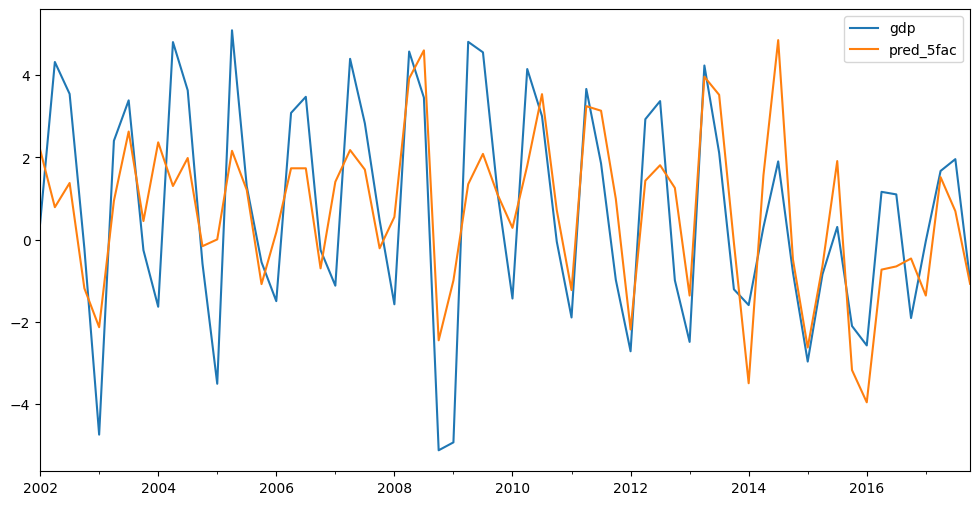

In [290]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_5fac'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

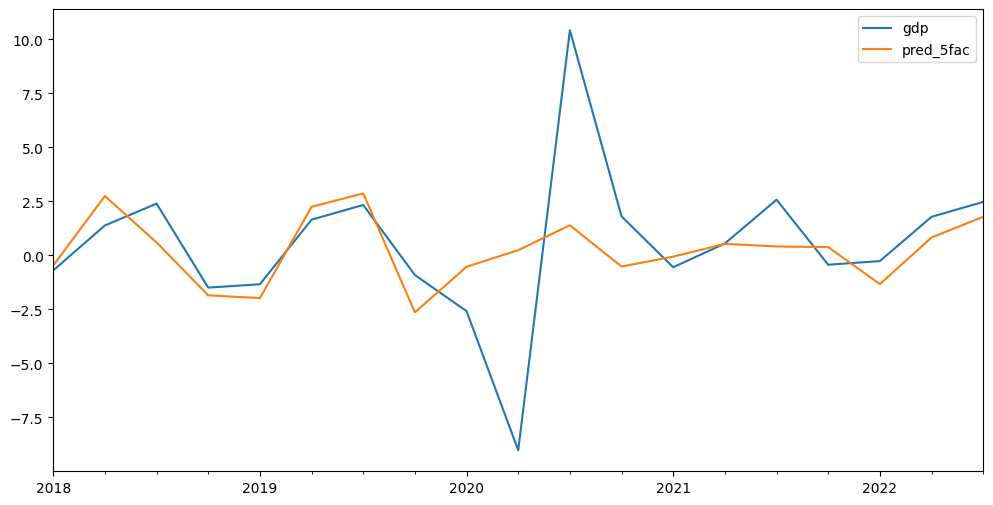

In [291]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_5fac'] = list_5fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD e MAPE

In [292]:
# Métricas IN-SAMPLE

rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac'])
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac'])
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

1.827842929311588

1.5208702710661632

1.8030293659950782


In [293]:
# Métricas OUT-OF-SAMPLE

rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

3.1977164484578124

1.9005002265647193

0.9355200793639435


# Análise dos resíduos

## Autocorrelação

c:\Users\HENRI\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


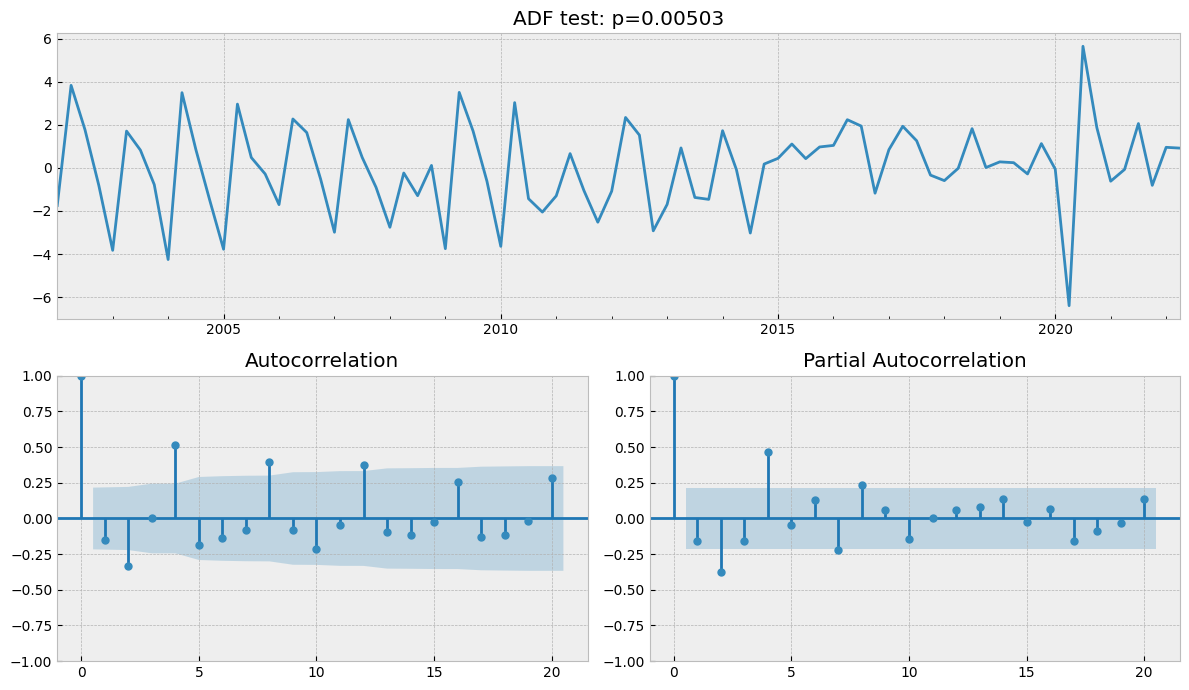

In [294]:
tsplot(dfm_5fac.resid, lags = 20)

In [295]:
# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 12)

# Resultados

print(round(lb_result, 4))

    lb_stat  lb_pvalue
1    0.2629     0.6082
2    6.2955     0.0429
3    7.6886     0.0529
4   26.6840     0.0000
5   30.2354     0.0000
6   34.3271     0.0000
7   34.5249     0.0000
8   49.1534     0.0000
9   52.2317     0.0000
10  55.9797     0.0000
11  56.0087     0.0000
12  71.7388     0.0000


In [296]:
# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_5fac.resid, lags = 8)

# Resultados

print(round(lb_result, 4))

   lb_stat  lb_pvalue
1   1.9929     0.1580
2  11.7377     0.0028
3  11.7380     0.0083
4  35.3357     0.0000
5  38.4716     0.0000
6  40.2294     0.0000
7  40.8176     0.0000
8  55.5097     0.0000


## Heteroscedasticidade

In [297]:
# IN-SAMPLE

het_breuschpagan(dfm.resid.loc['2003Q3':'2017Q4',], X_train.loc['2003Q3':'2017Q4',])

(47.95304400964796,
 0.020040248193949207,
 4.157035673304719,
 0.00016508833651926658)

In [298]:
# OUT-SAMPLE

het_breuschpagan(dfm_5fac.resid.loc['2003Q3':'2022Q2',], new_data.loc['2003Q3':'2022Q2',])

(56.72131377727585,
 0.0032212252084582805,
 4.045493844483237,
 1.1606573542405184e-05)

## Distribuição e comportamento no tempo

<AxesSubplot: xlabel='date', ylabel='resid'>

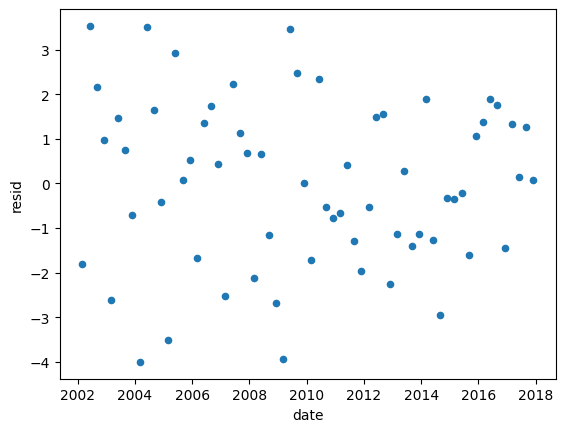

In [299]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

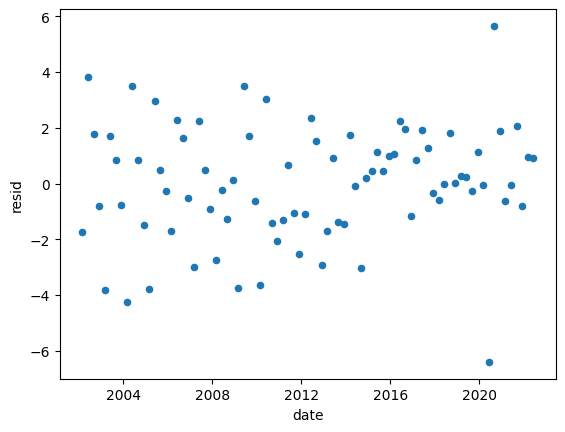

In [300]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_5fac.resid.index, 'resid':dfm_5fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

# Modelo: adicionando a dinâmica

## Regressões

In [301]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5', 
              data = train)
dfm = reg.fit(cov_type = 'HC1')
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     82.02
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           2.61e-27
Time:                        00:03:28   Log-Likelihood:                -67.253
No. Observations:                  60   AIC:                             160.5
Df Residuals:                      47   BIC:                             187.7
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5492      0.137      3.998      0.0

In [302]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit(cov_type = 'HC1')
pred = dfm_5fac.predict(test.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 +'
              'F1 + F1_4 +'
              'F2 + F2_2 +'
              'F3 + F3_1 + F3_2 + F3_3 +'
              'F4 + '
              'F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit(cov_type = 'HC1')
    pred = dfm_5fac.predict(test.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac

[-0.4912710783624575,
 2.497781025522477,
 1.6707932414917885,
 -1.4165483268831314,
 -1.1082229356774629,
 1.0119557133725063,
 2.2808468218930424,
 -0.7902304158134803,
 -3.102499815853978,
 -6.643346798822458,
 10.038748519179647,
 1.7226935973460678,
 -2.4652307453504507,
 -1.6404723194240927,
 3.116314617006353,
 -0.2839354087985188,
 -1.4501750694742326,
 0.7414629929235301,
 0.5366801985782605]

In [303]:
print(dfm_5fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     128.8
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           1.90e-40
Time:                        00:03:29   Log-Likelihood:                -87.908
No. Observations:                  78   AIC:                             201.8
Df Residuals:                      65   BIC:                             232.5
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6993      0.107      6.565      0.0

## Performance

### Previsões

<AxesSubplot: >

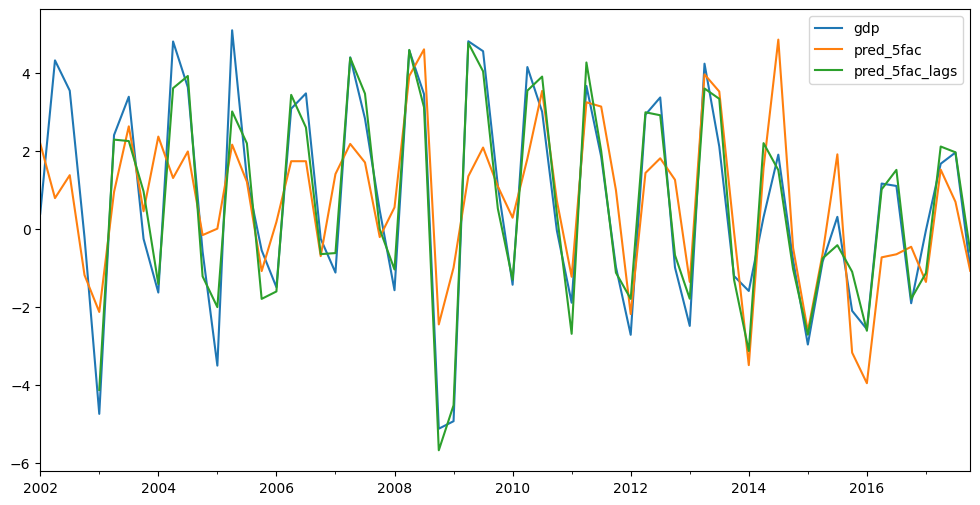

In [304]:
# Previsões IN-SAMPLE

forecasts_insample['pred_5fac_lags'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

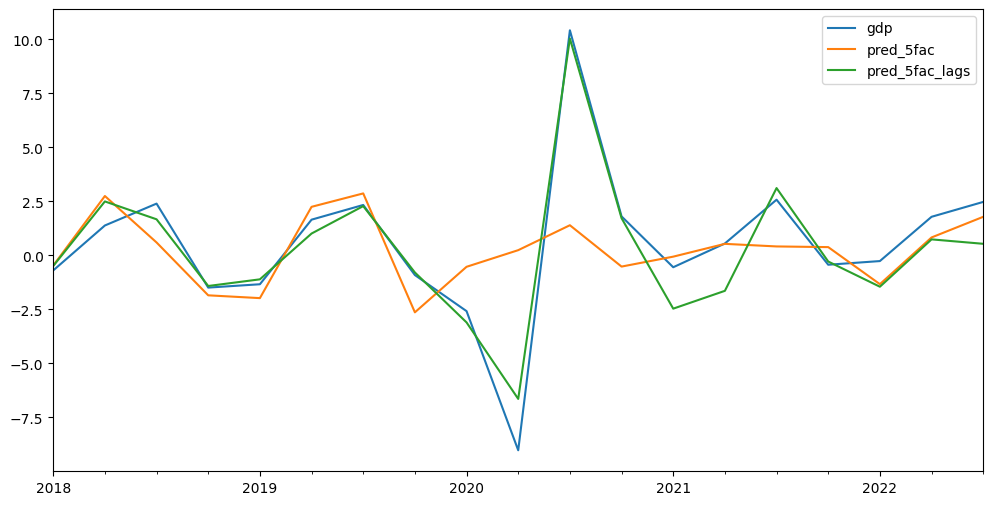

In [305]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample['pred_5fac_lags'] = list_5fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD, MAPE

In [306]:
# Métricas IN-SAMPLE

forecasts_insample = forecasts_insample.dropna(axis = 0)
rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags'].dropna())
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_5fac_lags'].dropna())
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

0.7422590125610766

0.5744389352375497

1.1538411103809598


In [307]:
# Métricas OUT-OF-SAMPLE

forecasts_outsample = forecasts_outsample.dropna(axis = 0)
rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_5fac_lags'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

1.1103516795764683

0.8153308003424423

0.8748831177817384


# Análise dos resíduos

## Autocorrelação

c:\Users\HENRI\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


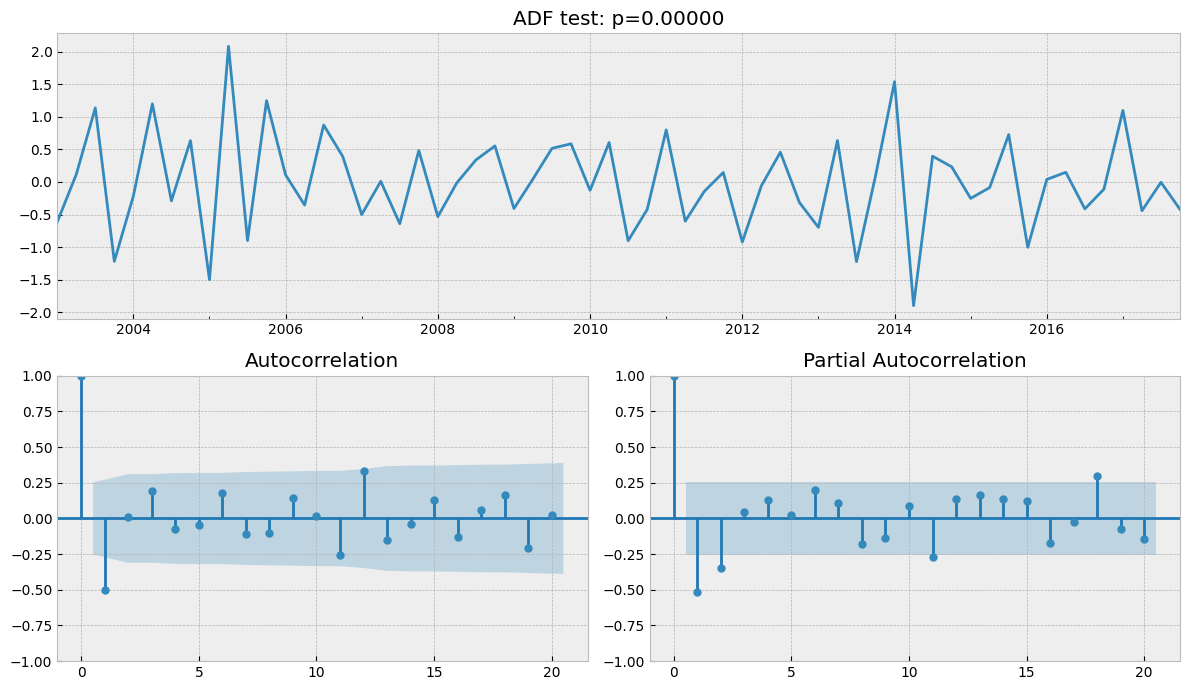

In [308]:
tsplot(dfm.resid, lags = 20)

In [309]:
# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 12)

# Resultados

print(round(lb_result, 4))

    lb_stat  lb_pvalue
1   15.9843     0.0001
2   15.9879     0.0003
3   18.3845     0.0004
4   18.7563     0.0009
5   18.8887     0.0020
6   21.0910     0.0018
7   21.9719     0.0026
8   22.6944     0.0038
9   24.1492     0.0041
10  24.1730     0.0072
11  29.2662     0.0021
12  37.9115     0.0002


In [310]:
# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_5fac.resid, lags = 12)

# Resultados

print(round(lb_result, 4))

    lb_stat  lb_pvalue
1   12.8115     0.0003
2   13.3119     0.0013
3   14.0002     0.0029
4   14.1376     0.0069
5   14.5893     0.0123
6   15.7085     0.0154
7   17.1074     0.0167
8   17.2927     0.0272
9   18.7241     0.0276
10  19.1293     0.0387
11  23.4561     0.0152
12  30.4074     0.0024


## Heteroscedasticidade

In [311]:
# Teste de heteroscedasticidade - IN-SAMPLE

het_breuschpagan(dfm.resid.loc['2003Q3':'2017Q4',], X_train.loc['2003Q3':'2017Q4',])

(33.901281811173796,
 0.2847967216337085,
 1.2252486890148049,
 0.29782144821668866)

In [312]:
# Teste de heteroscedasticidade - OUT-OF-SAMPLE

het_breuschpagan(dfm_5fac.resid.loc['2003Q3':'2022Q2',], new_data.loc['2003Q3':'2022Q2',])

(36.483784221582226,
 0.2288102068041408,
 1.2694839907234707,
 0.22890234503783854)

<AxesSubplot: xlabel='date', ylabel='resid'>

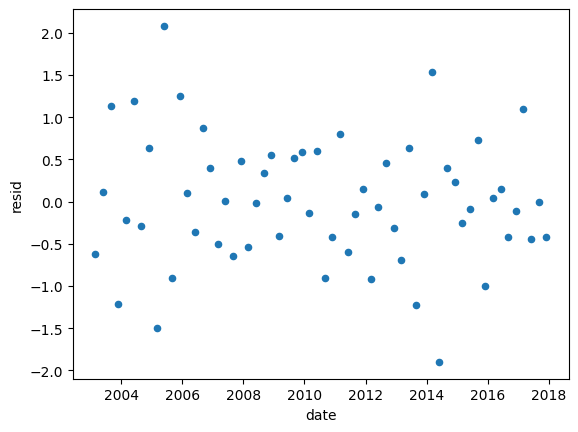

In [313]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

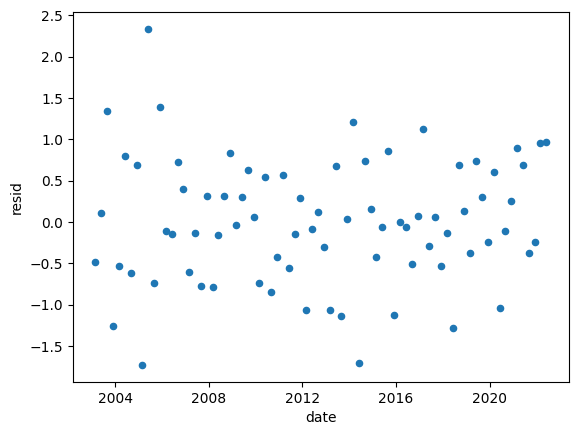

In [314]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_5fac.resid.index, 'resid':dfm_5fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')